# Processing the Dataset

In [5]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [7]:
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [9]:
!ls /kaggle/input/seg_train/seg_train
# /kaggle/input/intel-image-classification/seg_train/seg_train/

buildings  forest  glacier  mountain  sea  street


In [10]:
data_dir = "/kaggle/input/seg_train/seg_train/"
test_data_dir = "/kaggle/input/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [11]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [13]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [14]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [15]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [16]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

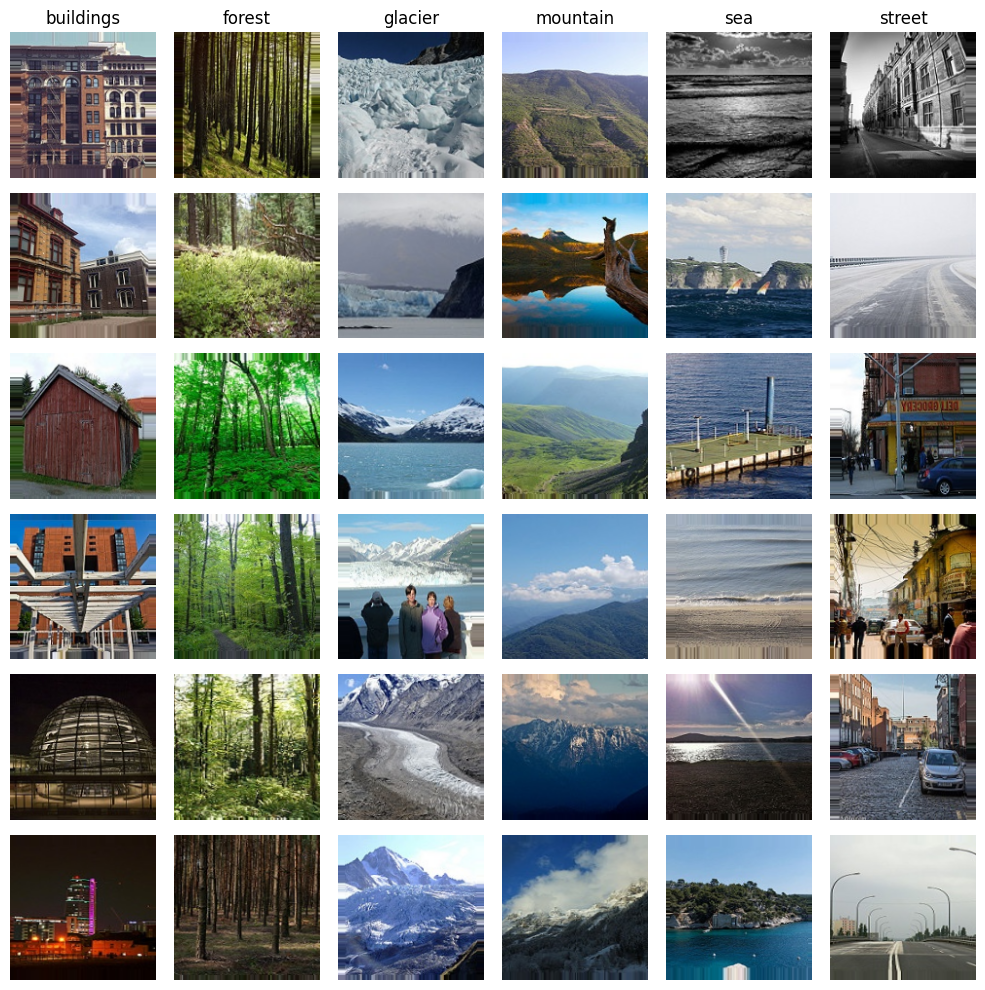

In [17]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [18]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [20]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [21]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. Fine-tune ResNet50 (default lr, epochs=60)

In [22]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
x = base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:03:32 22s/step - accuracy: 0.1562 - loss: 1.9564

I0000 00:00:1712618184.834779     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712618184.885871     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 97/176 ━━━━━━━━━━━━━━━━━━━━ 46s 594ms/step - accuracy: 0.2229 - loss: 1.7627

W0000 00:00:1712618241.856618     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.2568 - loss: 1.7253

W0000 00:00:1712618289.651949     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 157s 773ms/step - accuracy: 0.2572 - loss: 1.7249 - val_accuracy: 0.3495 - val_loss: 1.5475
Epoch 2/30


W0000 00:00:1712618320.142339     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 138s 475ms/step - accuracy: 0.4199 - loss: 1.4970 - val_accuracy: 0.4568 - val_loss: 1.4050
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 440ms/step - accuracy: 0.4616 - loss: 1.3759 - val_accuracy: 0.4775 - val_loss: 1.3163
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 438ms/step - accuracy: 0.5036 - loss: 1.2860 - val_accuracy: 0.5367 - val_loss: 1.2353
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 442ms/step - accuracy: 0.5332 - loss: 1.2201 - val_accuracy: 0.5464 - val_loss: 1.1923
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 445ms/step - accuracy: 0.5417 - loss: 1.1856 - val_accuracy: 0.5139 - val_loss: 1.1737
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 448ms/step - accuracy: 0.5697 - loss: 1.1375 - val_accuracy: 0.5556 - val_loss: 1.1438
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 448ms/step - accuracy: 0.5817 - loss: 1.1086 - val_accuracy: 0.5357 - val_loss: 1.1165
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 447ms/step - accuracy: 0.5768 - loss: 1.0874 - va

In [28]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.6537 - loss: 0.8785
Test Loss: 0.8769410848617554
Test Accuracy: 0.6610000133514404


W0000 00:00:1712620744.025171     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


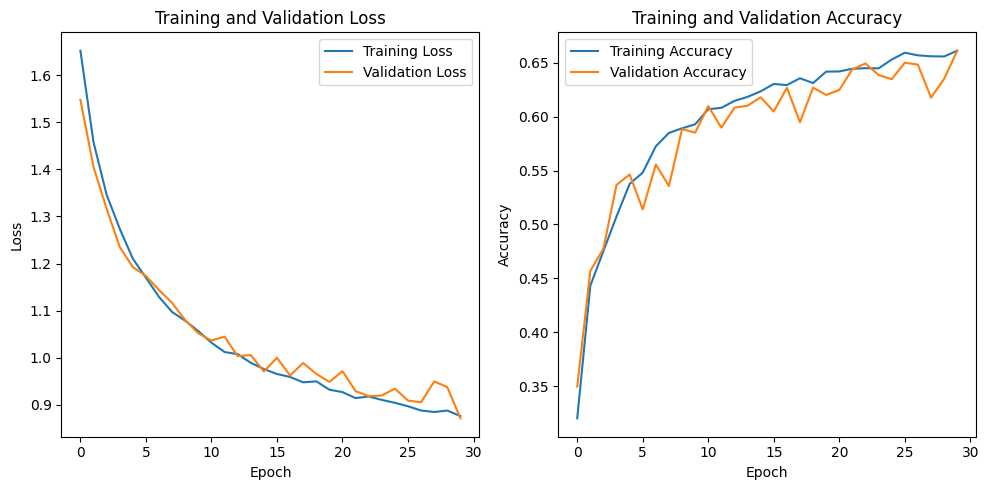

In [29]:
plot_learning_curve(history)

In [30]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step

W0000 00:00:1712620749.781408     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step


W0000 00:00:1712620769.485193     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


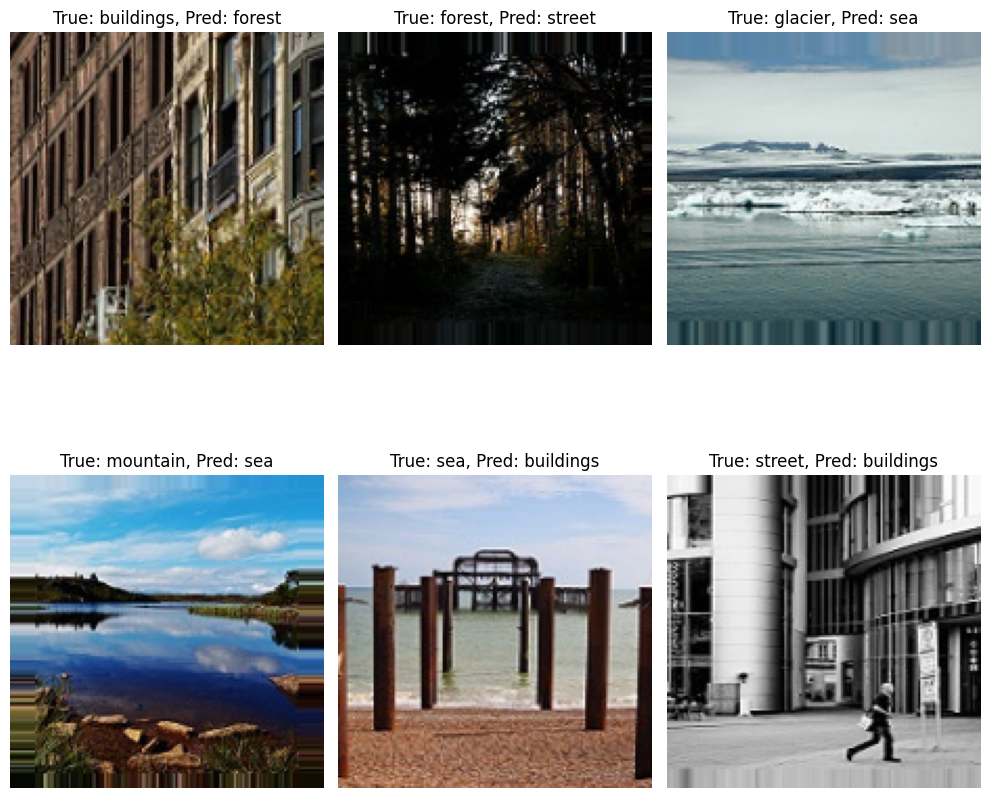

In [31]:
plot_worst_classified_examples(predictions)

# 2. Fine-tune InceptionV3 (default lr, epochs=60)

In [32]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
x2 = base_model2.output
x2 = GlobalAvgPool2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
predictions2 = Dense(num_classes, activation='softmax')(x2)

In [34]:
model2 = Model(inputs=base_model2.input, outputs=predictions2)

In [35]:
for layer in base_model2.layers:
    layer.trainable = False

In [36]:
model2.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 448ms/step - accuracy: 0.9675 - loss: 0.0878 - val_accuracy: 0.8994 - val_loss: 0.3483
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 433ms/step - accuracy: 0.9662 - loss: 0.0915 - val_accuracy: 0.8987 - val_loss: 0.3374
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 435ms/step - accuracy: 0.9717 - loss: 0.0847 - val_accuracy: 0.8855 - val_loss: 0.3755
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 442ms/step - accuracy: 0.9730 - loss: 0.0743 - val_accuracy: 0.8994 - val_loss: 0.3397
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 436ms/step - accuracy: 0.9737 - loss: 0.0761 - val_accuracy: 0.8841 - val_loss: 0.3745
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.9730 - loss: 0.0825 - val_accuracy: 0.8880 - val_loss: 0.3703
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 437ms/step - accuracy: 0.9735 - loss: 0.0740 - val_accuracy: 0.8795 - val_loss: 0.4124
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 434ms/step - accuracy: 0.9723 - loss: 0

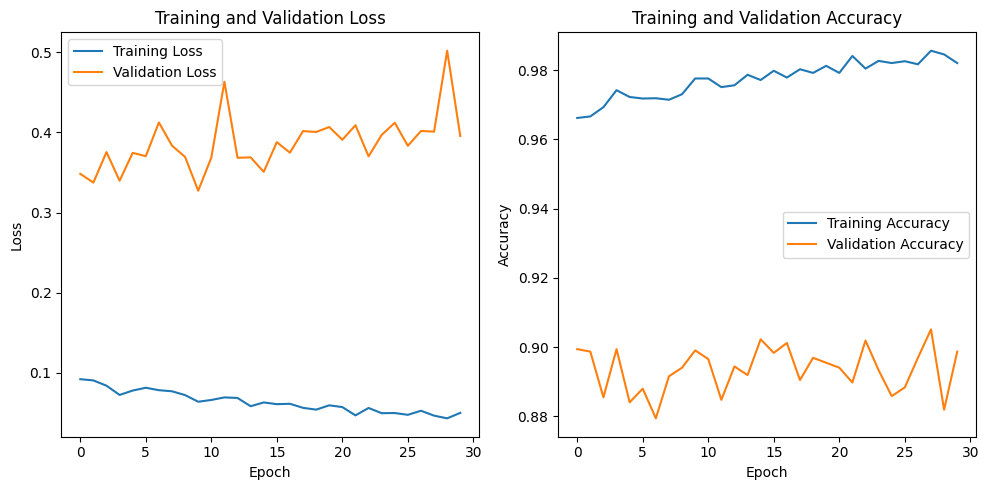

In [43]:
plot_learning_curve(history2)

In [44]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.8816 - loss: 0.4245
Test Loss: 0.420714408159256
Test Accuracy: 0.8840000033378601


In [45]:
predictions2 = model2.predict(test_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step


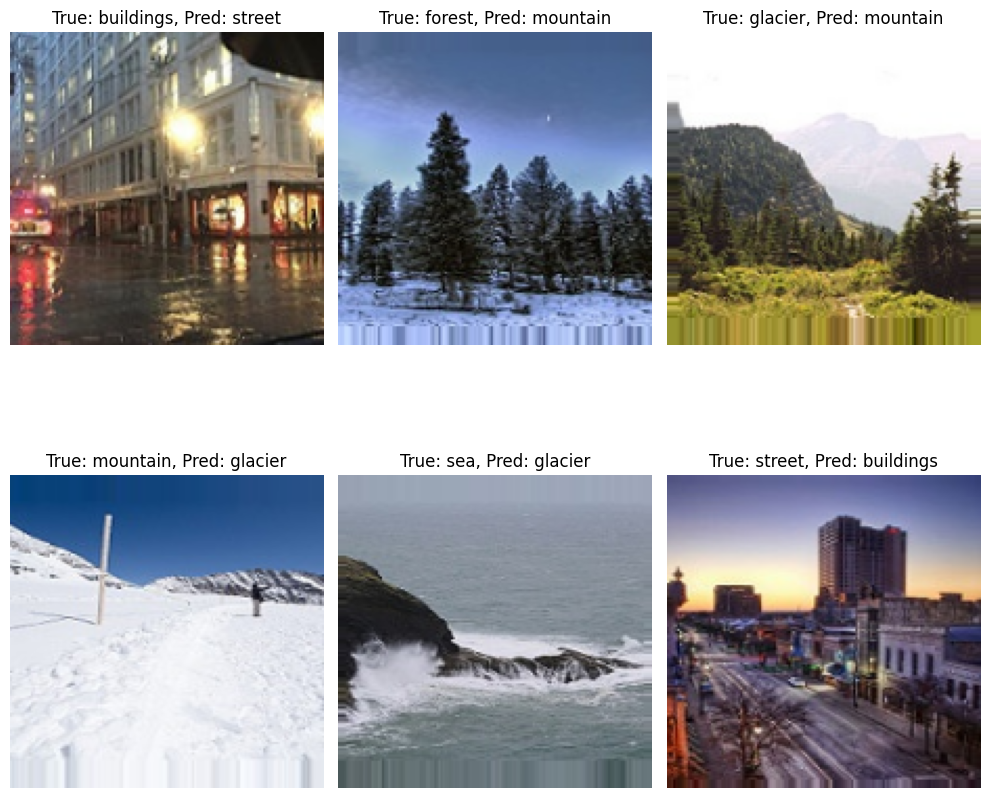

In [46]:
plot_worst_classified_examples(predictions2)